##Load MTCNN 
Multi-task Cascaded Convolutional Neural Networks to extract faces.
It is a keras librerary.

In [1]:
pip install mtcnn

In [2]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

Using TensorFlow backend.


0.1.0


In [3]:
# face detection for Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import numpy as np

In [4]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [5]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [6]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [7]:
# load a dataset of unkonwn persons
def load_unknown(path):
  unknownX , unknowny = list(), list()
  unknownX = load_faces(path)
  for files in listdir(path):
    unknowny.append('unknown')
  return asarray(unknownX), asarray(unknowny)

 **Load Data**

In [8]:
# load train dataset
trainX, trainy = load_dataset('/content/drive/My Drive/Newdata/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/My Drive/Newdata/val/')
# save arrays to one file in compressed format
savez_compressed('training-faces-dataset.npz', trainX, trainy)
savez_compressed('validation-faces-dataset.npz', testX, testy)
print(testX.shape, testy.shape)

>loaded 15 examples for class: jobiden
>loaded 14 examples for class: ben_afflek
>loaded 15 examples for class: elton_john
>loaded 16 examples for class: mindy_kaling
>loaded 15 examples for class: madonna
>loaded 15 examples for class: jerry_seinfeld
>loaded 16 examples for class: elon_musk
(106, 160, 160, 3) (106,)
>loaded 5 examples for class: jobiden
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: elon_musk
(35, 160, 160, 3) (35,)


In [9]:
# load dataset of unknown persons
unknownX , unknowny = load_unknown('/content/drive/My Drive/Newdata/unknown/')
# save arrays to one file in compressed format
savez_compressed('unknown-faces-dataset.npz', unknownX , unknowny)
print(unknownX.shape , unknowny.shape)

(8, 160, 160, 3) (8,)


##Load Facenet pre-trained model

In [10]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
model = load_model('/content/drive/My Drive/Facerecognition/Copy of facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##**Face embedding** 


In [11]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

In [12]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [13]:
# load the training faces dataset
data = load('training-faces-dataset.npz')
trainX, trainy = data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)

# load validation faces dataset
data = load('validation-faces-dataset.npz')
testX, testy = data['arr_0'], data['arr_1']
print('Loaded: ', testX.shape, testy.shape)

# load validation faces dataset
data = load('unknown-faces-dataset.npz')
unknownX, unknowny = data['arr_0'], data['arr_1']
print('Loaded: ', unknownX.shape , unknowny.shape)

Loaded:  (106, 160, 160, 3) (106,)
Loaded:  (35, 160, 160, 3) (35,)
Loaded:  (8, 160, 160, 3) (8,)


In [14]:
# convert each face in the training set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the validation set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# convert each face in the unknown set to an embedding
newunknownX = list()
for face_pixels in unknownX:
	embedding = get_embedding(model, face_pixels)
	newunknownX.append(embedding)
newunknownX = asarray(newunknownX)
print(newunknownX.shape)

(106, 128)
(35, 128)
(8, 128)


In [15]:
# save arrays to one file in compressed format
savez_compressed('training-faces-embeddings.npz', newTrainX, trainy)

# save arrays to one file in compressed format
savez_compressed('validation-faces-embeddings.npz', newTestX, testy)

# save arrays to one file in compressed format
savez_compressed('unknown-faces-embeddings.npz', newunknownX, unknowny)

In [16]:
from sklearn.metrics import f1_score

#load validation-faces-embedding  data
data = load('validation-faces-embeddings.npz')
testX, testy = data['arr_0'], data['arr_1']
#load unknown-faces-embedding  data
data = load('unknown-faces-embeddings.npz')
unknownX, unknowny = data['arr_0'], data['arr_1']

newX = np.concatenate((testX,unknownX))
newy = np.concatenate((testy,unknowny))

Fit SVC classifier model

In [17]:
# develop a classifier for Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('training-faces-dataset.npz')
# load face embeddings
data = load('training-faces-embeddings.npz')
trainX, trainy = data['arr_0'], data['arr_1']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(newy)
trainy = out_encoder.transform(trainy)

In [18]:
# fit model
Modelsvm  = SVC(kernel='linear', probability=True, random_state=500)
Modelsvm.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=500, shrinking=True, tol=0.001,
    verbose=False)

##Another Model based on distance 


In [19]:
def img_to_emmbeding(path,model):
  image = Image.open(path)
	# convert to RGB, if needed
  image = image.convert('RGB')
	# convert to array
  pixels = asarray(image)
	# create the detector, using default weights
  detector = MTCNN()
	# detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
  # bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
  # extract the face
  face = pixels[y1:y2, x1:x2]
  # resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize((160,160))
  face_array = asarray(image)
  emmbeding = get_embedding(model,face_array)
  return emmbeding

In [20]:
database = {}
database["jobiden"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/jobiden/zrAovB.jpg", model)
database["elon_musk"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/elon_musk/161871.jpg", model)
database["elton_john"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/elton_john/httpftqncomymusicLxZeltonjohnjpg.jpg", model)
database["jerry_seinfeld"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/jerry_seinfeld/httpikinjaimgcomgawkermediaimageuploadsWmIuhdsrcedidjpgjpg.jpg", model)
database["madonna"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/madonna/httpsuploadwikimediaorgwikipediacommonsMadonnathAnnualGoldenGlobesAwardscroppedjpg.jpg", model)
database["mindy_kaling"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/mindy_kaling/httpgonetworthcomwpcontentuploadsthumbsjpg.jpg", model)
database["ben_afflek"] = img_to_emmbeding("/content/drive/My Drive/Newdata/train/ben_afflek/httpwwwrumenewscomwpcontentuploadsbenafflekxpng.jpg", model)

In [21]:
def who_are_you(emmbeding):
  min_dist=100
  for (name , encoding) in database.items():
    dist=np.linalg.norm(encoding-emmbeding)
    if dist < min_dist:
      min_dist=dist
      identity = name
  if min_dist > 10:
    #print("Not in the database.")
    present = False
  else:
    #print("it's " + str(identity) + ", the distance is " + str(min_dist))
    present = True
  return present, min_dist,identity

##Validation

Validation on SVC classifier

In [22]:
from sklearn.metrics import f1_score

#load validation-faces-embedding  data
data = load('validation-faces-embeddings.npz')
testX, testy = data['arr_0'], data['arr_1']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
testX = in_encoder.transform(testX)
# label encode targets
testy = out_encoder.transform(testy)

sample = testX
#expand_dims(testX, axis=0)
predy_classes = Modelsvm.predict(sample)
predy_prob = Modelsvm.predict_proba(sample)

#calculate F1 score 
f1_score(predy_classes,testy, average='weighted')

1.0

Validation after merging both method

In [24]:
def getclass(emmbeding):
  present, dist, name1 =  who_are_you(emmbeding)
  # prediction for the face
  samples = expand_dims(emmbeding, axis=0)
  #samples= in_encoder.transform(samples)
  yhat_class = Modelsvm.predict(samples)
  yhat_prob = Modelsvm.predict_proba(samples)

  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  name2 = out_encoder.inverse_transform(yhat_class)
  name2 = name2[0]

  if present and class_probability >=99.9999: 
    return name2
  elif present and class_probability <99:
    return 'unknown'
  elif present==False and name1==name2 and class_probability>=99.999:
   return name2
  else:
    return 'unknown'

In [25]:
def finalvalidation():
  predy_classes = list()
  for i in range(len(newX)):
    predy_classes.append(getclass(newX[i]))
  predy = out_encoder.transform(predy_classes)
  return predy

In [26]:
predy = finalvalidation()
f1_score(predy,newy, average='weighted')

0.9764622973925299

##Prediction

In [27]:
def predict(path):
  emmbeding = img_to_emmbeding(path,model)
  image = extract_face(path)
  present, dist, name1 =  who_are_you(emmbeding)
  # prediction for the face
  samples = expand_dims(emmbeding, axis=0)
  yhat_class = Modelsvm.predict(samples)
  yhat_prob = Modelsvm.predict_proba(samples)

  # get name
  class_index = yhat_class[0]
  class_probability = yhat_prob[0,class_index] * 100
  name2 = out_encoder.inverse_transform(yhat_class)
  name2 = name2[0]

  authorised = False
  if present and class_probability >=99.9999: 
    authorised = True
    print('Welcome %s'%name2)
  elif present and class_probability <99:
    print('Sorry you are not allowed')
  elif present==False and name1==name2 and class_probability>=99.999:
    authorised = True
    print('Welcome %s,,',name2)
  else:
    #if class_probability < 99.999:
    print('Sorry you are not allowed')
   # else:
      #print('Welcome %s'%name2)
  print('matching_accuracy is %.3f and distance is %.6f '%(class_probability, dist))
  pyplot.imshow(image)
  if authorised:
    title = '%s (%.3f)' % (name2, class_probability)
  else:
    title = 'unknown'
  pyplot.title(title)
  pyplot.show()
  return 

Sorry you are not allowed
matching_accuracy is 98.970 and distance is 14.017150 


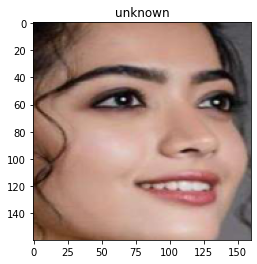

In [28]:
predict('/content/drive/My Drive/Newdata/unknown/BB12XCJF.jpeg')

Welcome jobiden
matching_accuracy is 100.000 and distance is 7.508875 


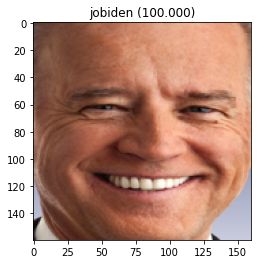

In [29]:
predict('/content/drive/My Drive/Newdata/val/jobiden/lJZ8sN.jpg')